<a href="https://colab.research.google.com/github/Ej0007/CCDEPLRL_PROJECT_COM211/blob/main/Fruit_Ripeness_Model_FINALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

Dataset URL: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
License(s): unknown
100% 3.58G/3.58G [01:47<00:00, 38.0MB/s]
100% 3.58G/3.58G [01:47<00:00, 35.8MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.09 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.18 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.24 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.37 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.51 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.02 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.12 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.21 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.31 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
train_folder = 'dataset/train'
new_train_folder = 'dataset/new_train'
validation_folder = 'dataset/validation'

os.makedirs(new_train_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)

classes = os.listdir(train_folder)

all_files = os.listdir(train_folder)

train_files, validation_files = train_test_split(all_files, test_size=0.2, random_state=42)

In [ ]:
#user-defined function to split the training folder into train and validation

def move_files(file_list, source_folder, destination_folder):
    for file_name in file_list:
        src_file = os.path.join(source_folder, file_name)
        dest_file = os.path.join(destination_folder, file_name)
        shutil.copy(src_file, dest_file)

In [ ]:
# Iterate over each class and split the files
for class_name in classes:
    class_folder = os.path.join(train_folder, class_name)
    class_files = os.listdir(class_folder)

    # Create corresponding class directories in new_train and validation folders
    os.makedirs(os.path.join(new_train_folder, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_folder, class_name), exist_ok=True)

    # Split the files into training and validation sets (80% train, 20% validation)
    train_files, validation_files = train_test_split(class_files, test_size=0.2, random_state=42)

    # Move the files to their respective folders
    move_files(train_files, class_folder, os.path.join(new_train_folder, class_name))
    move_files(validation_files, class_folder, os.path.join(validation_folder, class_name))

In [ ]:
#pre-process the images in the dataset and the batch size that will be used in the model training
img_height, img_width = 128, 128
batch_size = 100


train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/new_train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 8718 files belonging to 6 classes.
Found 2183 files belonging to 6 classes.
Found 2698 files belonging to 6 classes.


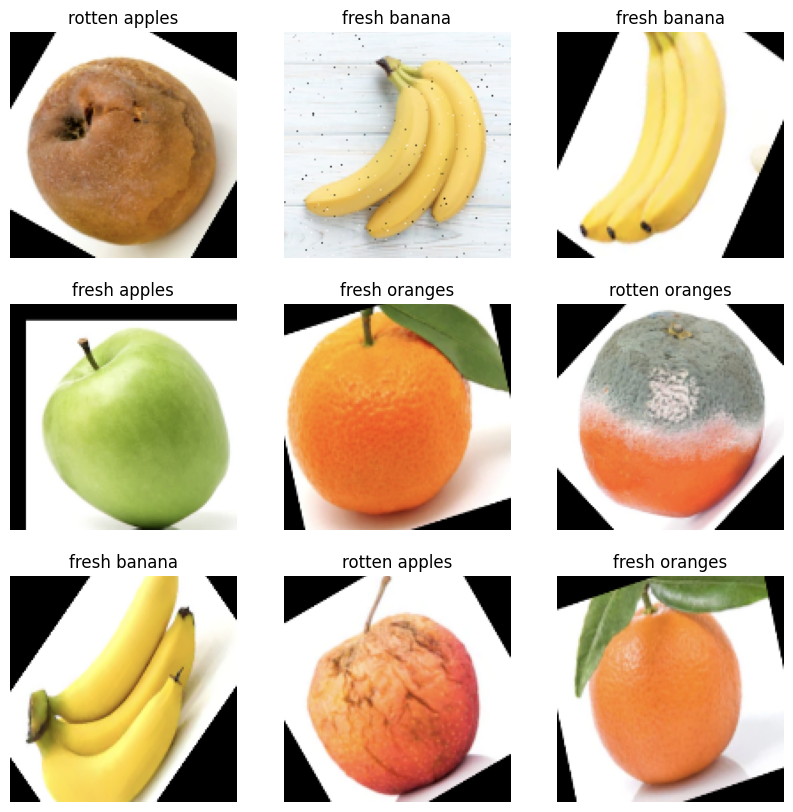

In [ ]:
class_names = ["fresh apples", "fresh banana", "fresh oranges", "rotten apples", "rotten banana", "rotten oranges"]
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.RandomFlip(),
     tf.keras.layers.RandomContrast(factor=0.2),

     tf.keras.layers.Conv2D(128, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(128, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(2, 2),

     tf.keras.layers.Conv2D(128, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(2, 2),

     tf.keras.layers.Conv2D(128, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(2, 2),

     tf.keras.layers.Conv2D(128, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(2, 2),

     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(200, activation="relu", input_shape=(128, 128, 3)),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(6, activation="softmax")
    ]
)

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 15,
    callbacks=[early_stopping]
)

Epoch 1/15
88/88 [==============================] - 37s 358ms/step - loss: 1.2782 - accuracy: 0.4727 - val_loss: 1.0131 - val_accuracy: 0.6056
Epoch 2/15
88/88 [==============================] - 35s 374ms/step - loss: 0.7061 - accuracy: 0.7424 - val_loss: 0.5877 - val_accuracy: 0.7850
Epoch 3/15
88/88 [==============================] - 34s 361ms/step - loss: 0.4636 - accuracy: 0.8439 - val_loss: 0.4869 - val_accuracy: 0.8321
Epoch 4/15
88/88 [==============================] - 34s 370ms/step - loss: 0.3910 - accuracy: 0.8666 - val_loss: 0.3394 - val_accuracy: 0.8821
Epoch 5/15
88/88 [==============================] - 33s 351ms/step - loss: 0.3088 - accuracy: 0.8914 - val_loss: 0.2273 - val_accuracy: 0.9170
Epoch 6/15
88/88 [==============================] - 34s 371ms/step - loss: 0.2738 - accuracy: 0.9067 - val_loss: 0.2628 - val_accuracy: 0.9047
Epoch 7/15
88/88 [==============================] - 34s 363ms/step - loss: 0.2408 - accuracy: 0.9166 - val_loss: 0.2171 - val_accuracy: 0.9199

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_contrast_3 (RandomC  (None, 128, 128, 3)       0         
 ontrast)                                                        
                                                                 
 conv2d_18 (Conv2D)          (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 63, 63, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 61, 61, 128)      

4/4 [==============================] - 0s 48ms/step


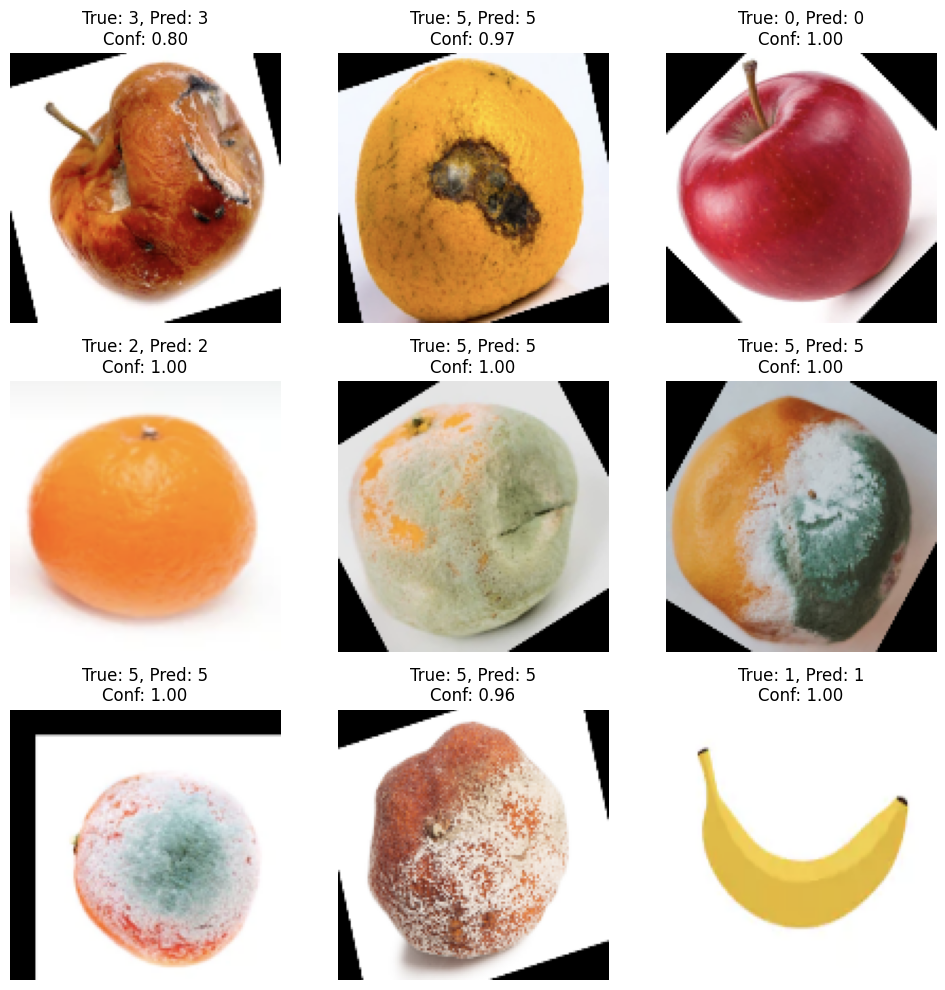

In [ ]:
# Get validation dataset predictions
val_images, val_labels = next(iter(validation_ds))
predictions = model.predict(val_images)

# Plot a few images with their predicted confidence scores
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(val_images[i].numpy().astype("uint8"))
    plt.title(f"True: {val_labels[i]}, Pred: {np.argmax(predictions[i])}\nConf: {np.max(predictions[i]):.2f}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
history_dict = history.history

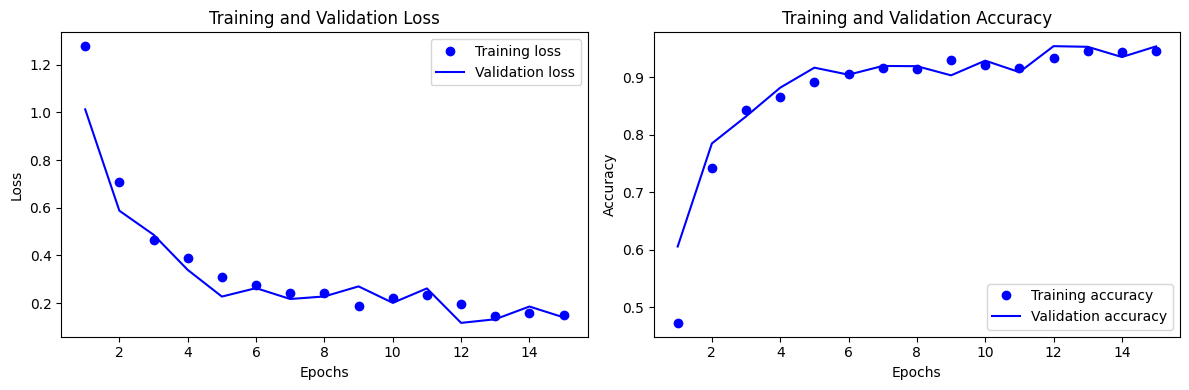

In [ ]:
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('model.keras')

85/85 [==============================] - 1s 14ms/step


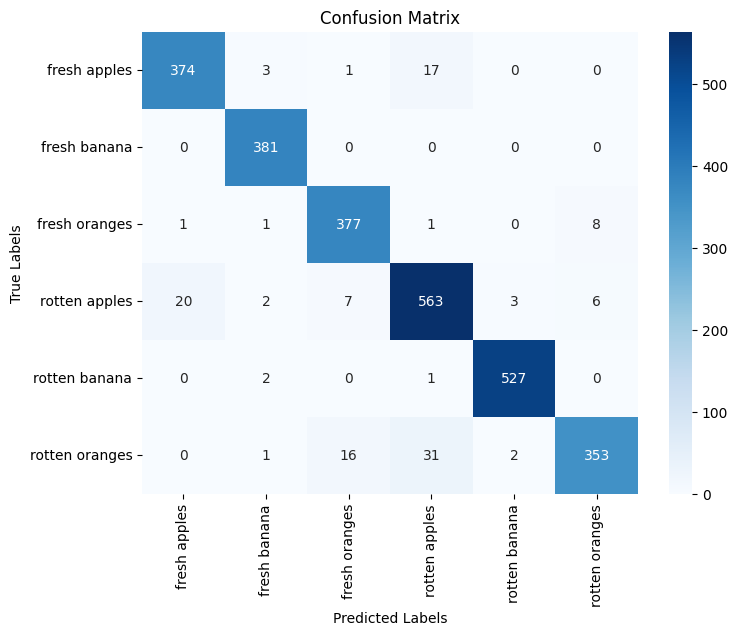

                precision    recall  f1-score   support

  fresh apples       0.95      0.95      0.95       395
  fresh banana       0.98      1.00      0.99       381
 fresh oranges       0.94      0.97      0.96       388
 rotten apples       0.92      0.94      0.93       601
 rotten banana       0.99      0.99      0.99       530
rotten oranges       0.96      0.88      0.92       403

      accuracy                           0.95      2698
     macro avg       0.96      0.95      0.95      2698
  weighted avg       0.95      0.95      0.95      2698

Accuracy: 0.95


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
# Extract images and labels from test dataset
X_test = []
y_test = []

for images, labels in test_ds:
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)


# Load the model
model = tf.keras.models.load_model('model.keras')

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

class_labels = ["fresh apples", "fresh banana", "fresh oranges", "rotten apples", "rotten banana", "rotten oranges"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print classification report
report = classification_report(y_test, y_pred_classes, target_names=class_labels)
print(report)

# Print accuracy score
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)